# Purpose
- goal is to use DLC-estimated key points and define behavioral epochs
- data is from Alex F from Knowles lab, and we want to quanitfy:

1. time in light box (time visible)
    - nose only
    - nose and ears
    - nose and ears and butt
2. distance to edge IN REAL COORDINATES
    - adjust marked coordinates to real coordinates (50cm2 box)
    - get animal position relative to corners
3. #, timing, location of rearing events
4. #, timing, location of jumps


# imports

In [1]:
import numpy as np
import pandas as pd
import glob, os, csv
import matplotlib.pyplot as plt

In [397]:
import cv2

In [88]:
from sklearn.model_selection import train_test_split
from scipy.io import arff
import math

# functions

In [387]:
def reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                for idx in np.arange(0,len(part.x)):
                    second_idx = np.max([0,idx-1])
                    if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                        part.y[idx] = np.nan
                    elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                        part.x[idx] = np.nan
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                part.x = part.x.interpolate()
                part.x=part.x.rolling(seconds*fps,min_periods=1).median()
                part.y = part.y.interpolate()
                part.y=part.y.rolling(seconds*fps,min_periods=1).median()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [423]:
def align_df(df):
    new_df=pd.DataFrame()
    # for each index, get the box coords, find transformation matrix, then apply it to all other points
    s1=[0,500]
    s2=[500,500]
    s3=[0,0]
    s4=[500,0]
    for idx in np.arange(0,len(df)):
        if idx%1000==0:
            print('at {} of {} rows'.format(idx,len(df)))
        # get box points
        p1=[df.box_bl.x[idx],df.box_bl.y[idx]] #0,500
        p2=[df.box_br.x[idx],df.box_br.y[idx]] #500,500
        p3=[df.box_tl.x[idx],df.box_tl.y[idx]] #0,0
        p4=[df.box_tr.x[idx],df.box_tr.y[idx]] #500,0
        # get transform matrix
        M = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))
        # apply transform matrix to other points
        sub_df=df[df.index==idx].copy()
        for i in np.arange(0,len(sub_df.columns),3):
            p1_0=sub_df.iloc[0,i]
            p1_1=sub_df.iloc[0,i+1]
            if np.isnan(p1_0):
                p1_0_new=np.nan
                p1_1_new=np.nan
            else:
                # set points
                pts = np.array([[[p1_0,p1_1]]],dtype='float32')
                # use transform matrix to un-warp the points
                [p1_0_new,p1_1_new]=cv2.perspectiveTransform(pts,M)[0][0]
            sub_df.iloc[0,i]=p1_0_new
            sub_df.iloc[0,i+1]=p1_1_new
        new_df=pd.concat([new_df,sub_df],axis=0)
    return new_df

# load an example file, preprocess data (exclude outliers, smooth)

In [382]:
filename = "/Users/dennise/Downloads/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv"
#filename = "/home/dennislab2/Desktop/videos/skok_alex_videos/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv"
df = pd.read_csv(filename,header=[1,2])
df

bodyparts      box_tl                              box_tr              \
         coords           x           y likelihood            x           y   
0             0  600.575623  141.166534   0.999926  1417.813110  146.198654   
1             1  600.653870  141.739182   0.999920  1417.510376  145.888626   
2             2  601.028015  141.864044   0.999900  1417.739380  145.986465   
3             3  600.710266  141.865433   0.999923  1417.394287  146.227692   
4             4  601.733398  142.436890   0.999883  1417.477783  146.626511   
...         ...         ...         ...        ...          ...         ...   
17969     17969  698.581726  189.737732   0.999886  1519.398804  178.036163   
17970     17970  698.699707  189.688950   0.999876  1519.541138  178.037872   
17971     17971  698.651367  189.868378   0.999853  1519.545654  178.007477   
17972     17972  698.689209  189.889374   0.999842  1519.403564  178.003250   
17973     17973  698.575134  189.794312   0.999882  1519.459961  178.141815   

                      box_bl                          ... paw_left_front  \
      likelihood           x            y likelihood  ...     likelihood   
0       0.999896  599.930908   963.720642   0.999816  ...       0.003097   
1       0.999871  600.273071   963.563293   0.999885  ...       0.002969   
2       0.999878  599.633789   963.442139   0.999852  ...       0.003193   
3       0.999874  599.766663   964.397156   0.999783  ...       0.004061   
4       0.999878  600.283203   963.613708   0.999855  ...       0.004815   
...          ...         ...          ...        ...  ...            ...   
17969   0.999831  692.969177  1006.179321   0.999672  ...       0.760865   
17970   0.999795  692.301025  1006.881348   0.999625  ...       0.853909   
17971   0.999801  692.366943  1006.928528   0.999730  ...       0.770654   
17972   0.999818  692.639587  1006.825500   0.999734  ...       0.548015   
17973   0.999858  692.984375  1005.576660   0.999609  ...       0.349669   

      paw_right_front                        paw_left_back              \
                    x           y likelihood             x           y   
0         1416.634644  953.704346   0.003026    599.411499  493.974457   
1          594.605652  955.166443   0.002901    599.251892  494.162750   
2          591.089905  969.911072   0.003280    599.420349  494.217773   
3          598.012634  601.100830   0.004063    599.233521  494.465210   
4          597.972168  599.684082   0.003776    599.319153  494.534576   
...               ...         ...        ...           ...         ...   
17969      937.939453  314.679871   0.770925    902.990417  359.494751   
17970      928.885803  312.539948   0.808792    899.551025  361.798157   
17971      920.332336  310.608978   0.822342    897.530823  363.673187   
17972      913.495972  306.482269   0.740434    895.799683  363.854156   
17973      902.113708  299.856262   0.542728    894.871643  362.002228   

                 paw_right_back                         
      likelihood              x           y likelihood  
0       0.003977    1417.489380  152.150040   0.006150  
1       0.004123    1423.055664  153.766418   0.006930  
2       0.004154    1423.182495  153.757614   0.007855  
3       0.004658     597.457642  609.455811   0.006398  
4       0.004616    1422.903687  154.051331   0.006106  
...          ...            ...         ...        ...  
17969   0.544118     943.644104  384.555450   0.954382  
17970   0.404393     943.479797  382.574219   0.952148  
17971   0.423555     941.696289  378.922821   0.864063  
17972   0.130281     942.752014  347.860657   0.463479  
17973   0.090921     942.171753  361.293945   0.439683  

[17974 rows x 46 columns]

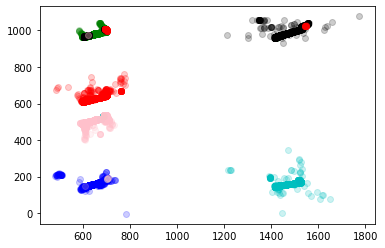

In [383]:
a=0
b=-1
plt.scatter(df.box_tl["x"][a:b],df.box_tl["y"][a:b],c='b',alpha=0.2)
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.2)
plt.scatter(df.box_bl["x"][a:b],df.box_bl["y"][a:b],c='g',alpha=0.2)
plt.scatter(df.box_br["x"][a:b],df.box_br["y"][a:b],c='k',alpha=0.2)
plt.scatter(df.opening_bottom["x"][a:b],df.opening_bottom["y"][a:b],c='r',alpha=0.2)
plt.scatter(df.opening_top["x"][a:b],df.opening_top["y"][a:b],c='pink',alpha=0.2)
plt.show()

## which rolling window is "good" at discarding random jumps in assignment but still capturing the slides?

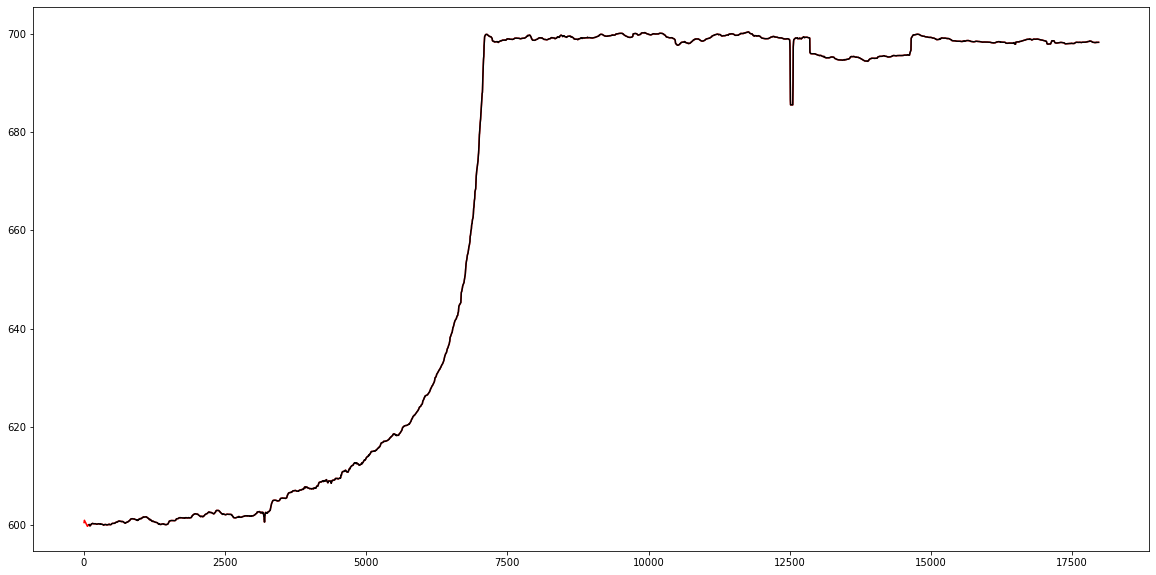

In [384]:
s = df.box_tl["x"]
seconds=3
fps=30
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps,min_periods=1).median(),c='r')
plt.plot(s.rolling(seconds*fps).median(),c='k')
#plt.xlim((0,100))
plt.show()

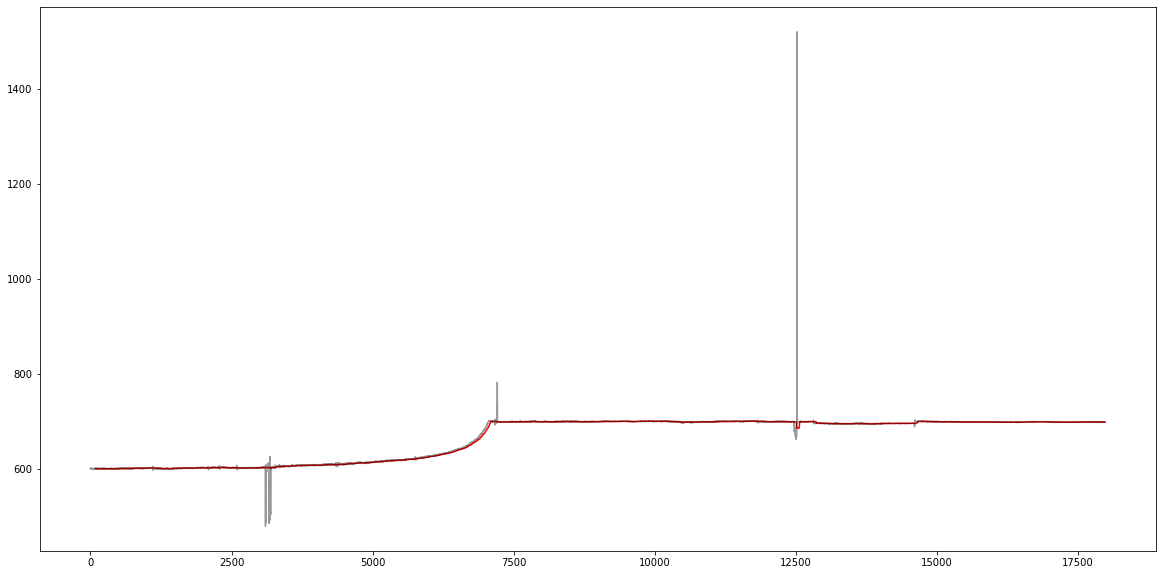

In [385]:
s = df.box_tl["x"]
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps).median(),c='r')
plt.plot(s,c='k',alpha=0.4)
plt.show()

### what adjustments do we need for body parts?

In [386]:
part = df.tail_base
part

,x,y,likelihood
0,598.828674,493.486237,0.008742
1,598.874146,493.520447,0.008749
2,598.919128,493.559875,0.008887
3,599.036743,493.676971,0.009111
4,593.922119,493.186646,0.008729
...,...,...,...
17969,911.676392,393.177826,0.999731
17970,911.796021,393.423065,0.999720
17971,912.262878,392.658478,0.999845
17972,912.982849,390.989838,0.999910


In [388]:
new_df=reformat_df(df,0.9,1000,15,3,30)

C:\Users\dennise\AppData\Local\Temp/ipykernel_9276/2221142894.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan
C:\Users\dennise\AppData\Local\Temp/ipykernel_9276/2221142894.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y[idx] = np.nan
C:\Users\dennise\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [389]:
new_df

box_bl                               box_br               \
                x            y likelihood            x            y   
0      599.930908   963.720642   0.999816  1414.975220   962.655518   
1      600.101990   963.641968   0.999885  1415.067139   962.684021   
2      599.930908   963.563293   0.999852  1414.975220   962.655518   
3      599.848785   963.641968   0.999783  1415.067139   962.684021   
4      599.930908   963.613708   0.999855  1415.159058   962.712524   
...           ...          ...        ...          ...          ...   
17969  692.759766  1005.954803   0.999672  1531.512146  1018.393829   
17970  692.759766  1005.954803   0.999625  1531.512146  1018.393829   
17971  692.759766  1005.954803   0.999730  1531.512146  1018.385437   
17972  692.759766  1005.954803   0.999734  1531.512146  1018.385437   
17973  692.770569  1005.931671   0.999609  1531.512146  1018.385437   

                      box_tl                              box_tr  ...  \
      likelihood           x           y likelihood            x  ...   
0       0.999792  600.575623  141.166534   0.999926  1417.813110  ...   
1       0.999763  600.614746  141.452858   0.999920  1417.661743  ...   
2       0.999830  600.653870  141.739182   0.999900  1417.739380  ...   
3       0.999784  600.682068  141.801613   0.999923  1417.624878  ...   
4       0.999807  600.710266  141.864044   0.999883  1417.510376  ...   
...          ...         ...         ...        ...          ...  ...   
17969   0.997551  698.265045  189.274338   0.999886  1519.408508  ...   
17970   0.997794  698.271545  189.278542   0.999876  1519.408508  ...   
17971   0.998031  698.275543  189.281776   0.999853  1519.408508  ...   
17972   0.997953  698.275543  189.281776   0.999842  1519.403564  ...   
17973   0.998206  698.275543  189.281776   0.999882  1519.403564  ...   

      paw_right_back paw_right_front                  tail_base              \
          likelihood               x   y likelihood           x           y   
0           0.006150             NaN NaN   0.003026         NaN         NaN   
1           0.006930             NaN NaN   0.002901         NaN         NaN   
2           0.007855             NaN NaN   0.003280         NaN         NaN   
3           0.006398             NaN NaN   0.004063         NaN         NaN   
4           0.006106             NaN NaN   0.003776         NaN         NaN   
...              ...             ...  ..        ...         ...         ...   
17969       0.954382             NaN NaN   0.770925  911.676392  393.177826   
17970       0.952148             NaN NaN   0.808792  911.796021  393.423065   
17971       0.864063             NaN NaN   0.822342  912.262878  392.658478   
17972       0.463479             NaN NaN   0.740434  912.982849  390.989838   
17973       0.439683             NaN NaN   0.542728  914.530090  386.379028   

                    tail_tip                         
      likelihood           x           y likelihood  
0       0.008742         NaN         NaN   0.008444  
1       0.008749         NaN         NaN   0.010901  
2       0.008887         NaN         NaN   0.010367  
3       0.009111         NaN         NaN   0.014907  
4       0.008729         NaN         NaN   0.011806  
...          ...         ...         ...        ...  
17969   0.999731  821.305176  487.758423   0.997880  
17970   0.999720  821.612976  487.403870   0.998094  
17971   0.999845  821.693970  487.485687   0.997955  
17972   0.999910  822.745972  486.795990   0.997914  
17973   0.999966  826.346802  484.334503   0.998515  

[17974 rows x 45 columns]

In [390]:
#filename[:-4]+"_adj.csv"
new_df.to_csv(filename[:-4]+"_adj.csv")

In [391]:
new_df = pd.read_csv(filename[:-4]+"_adj.csv",header=[0,1],index_col=0)

In [392]:
new_df

box_bl                               box_br               \
                x            y likelihood            x            y   
0      599.930908   963.720642   0.999816  1414.975220   962.655518   
1      600.101990   963.641968   0.999885  1415.067139   962.684021   
2      599.930908   963.563293   0.999852  1414.975220   962.655518   
3      599.848785   963.641968   0.999783  1415.067139   962.684021   
4      599.930908   963.613708   0.999855  1415.159058   962.712524   
...           ...          ...        ...          ...          ...   
17969  692.759766  1005.954803   0.999672  1531.512146  1018.393829   
17970  692.759766  1005.954803   0.999625  1531.512146  1018.393829   
17971  692.759766  1005.954803   0.999730  1531.512146  1018.385437   
17972  692.759766  1005.954803   0.999734  1531.512146  1018.385437   
17973  692.770569  1005.931671   0.999609  1531.512146  1018.385437   

                      box_tl                              box_tr  ...  \
      likelihood           x           y likelihood            x  ...   
0       0.999792  600.575623  141.166534   0.999926  1417.813110  ...   
1       0.999763  600.614746  141.452858   0.999920  1417.661743  ...   
2       0.999830  600.653870  141.739182   0.999900  1417.739380  ...   
3       0.999784  600.682068  141.801613   0.999923  1417.624878  ...   
4       0.999807  600.710266  141.864044   0.999883  1417.510376  ...   
...          ...         ...         ...        ...          ...  ...   
17969   0.997551  698.265045  189.274338   0.999886  1519.408508  ...   
17970   0.997794  698.271545  189.278542   0.999876  1519.408508  ...   
17971   0.998031  698.275543  189.281776   0.999853  1519.408508  ...   
17972   0.997953  698.275543  189.281776   0.999842  1519.403564  ...   
17973   0.998206  698.275543  189.281776   0.999882  1519.403564  ...   

      paw_right_back paw_right_front                  tail_base              \
          likelihood               x   y likelihood           x           y   
0           0.006150             NaN NaN   0.003026         NaN         NaN   
1           0.006930             NaN NaN   0.002901         NaN         NaN   
2           0.007855             NaN NaN   0.003280         NaN         NaN   
3           0.006398             NaN NaN   0.004063         NaN         NaN   
4           0.006106             NaN NaN   0.003776         NaN         NaN   
...              ...             ...  ..        ...         ...         ...   
17969       0.954382             NaN NaN   0.770925  911.676392  393.177826   
17970       0.952148             NaN NaN   0.808792  911.796021  393.423065   
17971       0.864063             NaN NaN   0.822342  912.262878  392.658478   
17972       0.463479             NaN NaN   0.740434  912.982849  390.989838   
17973       0.439683             NaN NaN   0.542728  914.530090  386.379028   

                    tail_tip                         
      likelihood           x           y likelihood  
0       0.008742         NaN         NaN   0.008444  
1       0.008749         NaN         NaN   0.010901  
2       0.008887         NaN         NaN   0.010367  
3       0.009111         NaN         NaN   0.014907  
4       0.008729         NaN         NaN   0.011806  
...          ...         ...         ...        ...  
17969   0.999731  821.305176  487.758423   0.997880  
17970   0.999720  821.612976  487.403870   0.998094  
17971   0.999845  821.693970  487.485687   0.997955  
17972   0.999910  822.745972  486.795990   0.997914  
17973   0.999966  826.346802  484.334503   0.998515  

[17974 rows x 45 columns]

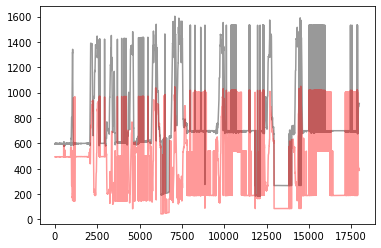

In [393]:
#plt.figure(figsize=(20,10))
plt.plot(part.x,c='k',alpha=0.4)
plt.plot(part.y,c='r',alpha=.4)
plt.show()

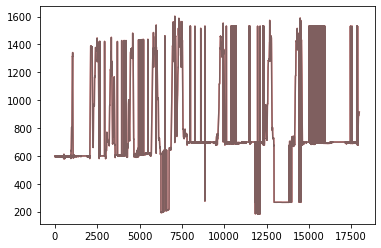

In [394]:
#plt.figure(figsize=(20,10))
#plt.plot(part.y,c='k')
plt.plot(part.x.interpolate(limit=15),c='r',alpha=1)
plt.plot(part.x.interpolate(limit=5),c='c',alpha=0.5)
plt.show()

# preprocessing thoughts 

let's say for now,
- for corners, rolling median of 90 (frames, 3 sec)
- interpolating between nans limit = 15 (.5 sec)

### ~TODO~ Done:
1. first, apply the above lessons to an entire dataframe, save it
2. should make box, and find region (in px) that correspond to 5 cm from edge (of the 50x50cm box)
3. extract useful info
    a. how much time did the animal spend visible?
        i. just nose?
        ii. nose + ears?
        iii. nose + ears + tail base?

## affine transform of points to correct for sliding FOV

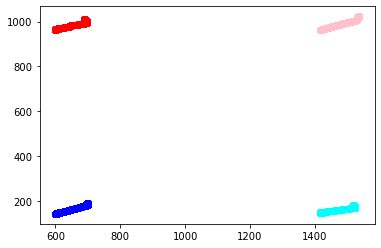

In [418]:
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='r') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='pink') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='cyan') #500,0mm

In [419]:
s1=[0,500]
s2=[500,500]
s3=[0,0]
s4=[500,0]
idx=1000
p1=[new_df.box_bl.x[idx],new_df.box_bl.y[idx]] #0,500
p2=[new_df.box_br.x[idx],new_df.box_br.y[idx]] #500,500
p3=[new_df.box_tl.x[idx],new_df.box_tl.y[idx]] #0,0
p4=[new_df.box_tr.x[idx],new_df.box_tr.y[idx]] #500,0
print(p1,p2,p3,p4)
print(s1,s2,s3,s4)

[601.0762634277344, 965.1229858398438] [1416.7677612304688, 962.7210388183594] [601.4052429199219, 142.02486419677734] [1416.6018676757812, 147.32157135009766]
[0, 500] [500, 500] [0, 0] [500, 0]


In [420]:
new_df.box_bl.x

0        599.930908
1        600.101990
2        599.930908
3        599.848785
4        599.930908
            ...    
17969    692.759766
17970    692.759766
17971    692.759766
17972    692.759766
17973    692.770569
Name: x, Length: 17974, dtype: float64

In [421]:
# get a transform matrix
A2 = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))

# set points
pts = np.array([[p1]],dtype='float32')

# use transform matrix to un-warp the points
cv2.perspectiveTransform(pts,A2)

array([[[  0., 500.]]], dtype=float32)

In [404]:
aligned_df=align_df(new_df)
aligned_df

at 0 of 17974 rows
at 1000 of 17974 rows
at 2000 of 17974 rows
at 3000 of 17974 rows
at 4000 of 17974 rows
at 5000 of 17974 rows
at 6000 of 17974 rows
at 7000 of 17974 rows
at 8000 of 17974 rows
at 9000 of 17974 rows
at 10000 of 17974 rows
at 11000 of 17974 rows
at 12000 of 17974 rows
at 13000 of 17974 rows
at 14000 of 17974 rows
at 15000 of 17974 rows
at 16000 of 17974 rows
at 17000 of 17974 rows


### let's see what the data look like after adjustment

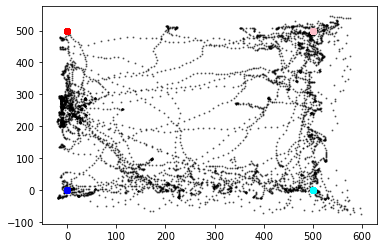

In [425]:
plt.scatter(aligned_df.nose['x'],aligned_df.nose['y'],c='k',s=1,alpha=0.5)
plt.scatter(aligned_df.box_bl['x'],aligned_df.box_bl['y'],c='r')
plt.scatter(aligned_df.box_br['x'],aligned_df.box_br['y'],c='pink')
plt.scatter(aligned_df.box_tl['x'],aligned_df.box_tl['y'],c='b')
plt.scatter(aligned_df.box_tr['x'],aligned_df.box_tr['y'],c='cyan')
plt.show()

In [426]:
nose_df = aligned_df.nose
nose_df

,x,y,likelihood
0,NaN,NaN,0.006743
1,NaN,NaN,0.007441
2,NaN,NaN,0.006668
3,NaN,NaN,0.007078
4,NaN,NaN,0.007489
...,...,...,...
17969,125.928253,71.330910,0.993589
17970,119.967941,70.642426,0.990155
17971,113.646049,69.631096,0.997681
17972,106.418182,69.043922,0.998823


In [408]:
~np.isnan(aligned_df.nose['x'])

0        False
1        False
2        False
3        False
4        False
         ...  
17969     True
17970     True
17971     True
17972     True
17973     True
Name: x, Length: 17974, dtype: bool

### how much time did the animal spend in the box?


In [409]:
nose_vals = ~np.isnan(aligned_df.nose['x'])
ear_l_vals = ~np.isnan(aligned_df.ear_left['x'])
ear_r_vals = ~np.isnan(aligned_df.ear_right['x'])
tail_vals = ~np.isnan(aligned_df.tail_base['x'])

print("frames with nose: {}".format(np.sum(nose_vals)))
frames_with_nose = np.sum(nose_vals)
print("frames with nose and ears: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals)))
print("frames with nose and ears and tail: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals*tail_vals)))
print("total frames {}".format(len(nose_vals)))

frames with nose: 5538
frames with nose and ears: 5314
frames with nose and ears and tail: 5044
total frames 17974


### how much time did it spend within 50mm of the 500mm^2 walls?


In [410]:
# can just use adj px values > 450 and < 50 (further vals are outside walls, but include jumps and rears which we do want to include)
nose_df['within50mm']=0
for idx in nose_df.index:
    xval=nose_df.x[idx]
    yval=nose_df.y[idx]
    if xval < 50 or xval > 450 or yval < 50 or yval > 450:
        nose_df.iloc[idx,3]=1
summed_val=np.sum(nose_df.within50mm)
print("frames with nose within 50mm of edge {}".format(summed_val))
print("fraction of frames where animal is inside the box AND within 50mm of an edge {}".format(summed_val/frames_with_nose))
print("fraction of frames where animal is inside and in the center (further than 50mm from an edge): {}".format((frames_with_nose-summed_val)/frames_with_nose))

C:\Users\dennise\AppData\Local\Temp/ipykernel_9276/4266349688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nose_df['within50mm']=0
C:\Users\dennise\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


frames with nose within 50mm of edge 4500
fraction of frames where animal is inside the box AND within 50mm of an edge 0.8125677139761647
fraction of frames where animal is inside and in the center (further than 50mm from an edge): 0.18743228602383533


In [411]:
print(5538/17973)
print(17973/29.93)

0.30812885995660155
600.5011693952556


### find first frame where it enters the 'center' of the box

In [412]:
tstdf=nose_df[~np.isnan(nose_df.x)]
tstdf=tstdf[tstdf.within50mm<1]
print("first frame in center (> 50mm from edge): {}".format(tstdf.index[0]))

first frame in center (> 50mm from edge): 946


In [413]:
# plot points in adjusted space

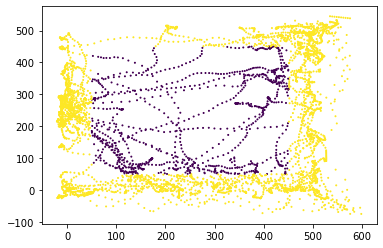

In [414]:
plt.scatter(nose_df.x,nose_df.y,c=nose_df.within50mm,s=1)

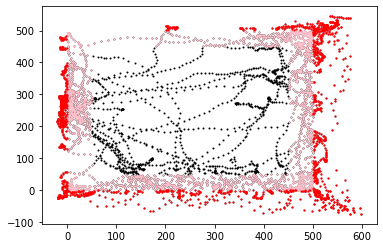

In [415]:
plt.scatter(nose_df.x,nose_df.y,s=1,c='k')
plt.scatter(nose_df.x[nose_df.x<50],nose_df.y[nose_df.x<50],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x>450],nose_df.y[nose_df.x>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.y<50],nose_df.y[nose_df.y<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y>450],nose_df.y[nose_df.y>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x<0],nose_df.y[nose_df.x<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.x>500],nose_df.y[nose_df.x>500],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y<0],nose_df.y[nose_df.y<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y>500],nose_df.y[nose_df.y>500],c='r',s=1)

### save out aligned data

In [416]:
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

## jump and rear classifications

In [429]:
Alex_annot_filename = '/Users/dennise/Desktop/boris_events_5.csv'
annots=pd.read_csv(Alex_annot_filename,skiprows=14,header=1)
aligned_df=pd.read_csv(filename[:-4]+"_aligned.csv",header=[0,1],index_col=0)
print(annots.head())
aligned_df.head()

     Time                                    Media file path  Total length  \
0  19.473  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
1  19.972  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
2  22.472  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
3  22.722  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
4  33.472  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   

     FPS  Subject Behavior  Behavioral category  Comment Status  
0  29.93      NaN    Light                  NaN      NaN  START  
1  29.93      NaN   Moving                  NaN      NaN  START  
2  29.93      NaN   Moving                  NaN      NaN   STOP  
3  29.93      NaN    Light                  NaN      NaN   STOP  
4  29.93      NaN    Light                  NaN      NaN  START  


box_bl                   box_br                          box_tl  \
              x      y likelihood      x      y likelihood             x   
0  0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1 -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2  0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3  1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4  0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   

                           box_tr  ... paw_right_back paw_right_front      \
              y likelihood      x  ...     likelihood               x   y   
0  0.000000e+00   0.999926  500.0  ...       0.006150             NaN NaN   
1 -1.428753e-14   0.999920  500.0  ...       0.006930             NaN NaN   
2  0.000000e+00   0.999900  500.0  ...       0.007855             NaN NaN   
3  0.000000e+00   0.999923  500.0  ...       0.006398             NaN NaN   
4 -2.856428e-14   0.999883  500.0  ...       0.006106             NaN NaN   

             tail_base                tail_tip                 
  likelihood         x   y likelihood        x   y likelihood  
0   0.003026       NaN NaN   0.008742      NaN NaN   0.008444  
1   0.002901       NaN NaN   0.008749      NaN NaN   0.010901  
2   0.003280       NaN NaN   0.008887      NaN NaN   0.010367  
3   0.004063       NaN NaN   0.009111      NaN NaN   0.014907  
4   0.003776       NaN NaN   0.008729      NaN NaN   0.011806  

[5 rows x 45 columns]

In [36]:
# looks like Alex's annots are 2s off a bit. need to align them with our frames.

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ... paw_right_back paw_right_front      \
                  y likelihood      x  ...     likelihood               x   y   
0      0.000000e+00   0.999926  500.0  ...       0.006150             NaN NaN   
1     -1.428753e-14   0.999920  500.0  ...       0.006930             NaN NaN   
2      0.000000e+00   0.999900  500.0  ...       0.007855             NaN NaN   
3      0.000000e+00   0.999923  500.0  ...       0.006398             NaN NaN   
4     -2.856428e-14   0.999883  500.0  ...       0.006106             NaN NaN   
...             ...        ...    ...  ...            ...             ...  ..   
17969  0.000000e+00   0.999886  500.0  ...       0.954382             NaN NaN   
17970 -2.758458e-14   0.999876  500.0  ...       0.952148             NaN NaN   
17971  0.000000e+00   0.999853  500.0  ...       0.864063             NaN NaN   
17972  0.000000e+00   0.999842  500.0  ...       0.463479             NaN NaN   
17973  0.000000e+00   0.999882  500.0  ...       0.439683             NaN NaN   

                   tail_base                          tail_tip              \
      likelihood           x           y likelihood          x           y   
0       0.003026         NaN         NaN   0.008742        NaN         NaN   
1       0.002901         NaN         NaN   0.008749        NaN         NaN   
2       0.003280         NaN         NaN   0.008887        NaN         NaN   
3       0.004063         NaN         NaN   0.009111        NaN         NaN   
4       0.003776         NaN         NaN   0.008729        NaN         NaN   
...          ...         ...         ...        ...        ...         ...   
17969   0.770925  132.831360  127.650238   0.999731  77.391563  185.406219   
17970   0.808792  132.903915  127.801270   0.999720  77.579056  185.189346   
17971   0.822342  133.188095  127.333473   0.999845  77.627518  185.239502   
17972   0.740434  133.631027  126.314026   0.999910  78.275650  184.820328   
17973   0.542728  134.578949  123.490120   0.999966  80.488739  183.321564   

                  
      likelihood  
0       0.008444  
1       0.010901  
2       0.010367  
3       0.014907  
4       0.011806  
...          ...  
17969   0.997880  
17970   0.998094  
17971   0.997955  
17972   0.997914  
17973   0.998515  

[17974 rows x 45 columns]

### first predicted entry

In [82]:
first_predicted=aligned_df[aligned_df.nose.x>-100].index[0]
first_annotated = annots.Time[0]
print("first frame with predicted entry {}".format(first_predicted))
print("first annotated entry {}".format(first_predicted))
print("first annotated entry * FPS {}".format(first_annotated*annots.FPS[0]))
print("offset in frames {}".format(first_annotated*annots.FPS[0]-first_predicted))
offset = first_annotated-(first_predicted/annots.FPS[0])
print("offset in seconds {}".format(offset))
annots['adj_time']=annots.Time-offset
annots['adj_frame']=annots.adj_time*annots.FPS

first frame with predicted entry 517
first annotated entry 517
first annotated entry * FPS 582.8268899999999
offset in frames 65.82688999999993
offset in seconds 2.1993615101904425


In [83]:
aligned_df['in_box']=float(0)
for idx in aligned_df.index:
    if np.isnan(aligned_df.nose.x[idx]):
        aligned_df.iloc[idx,-1]=0
    else:
        aligned_df.iloc[idx,-1]=1

In [84]:
annots_in_box=annots[annots.Behavior=='Light'].reset_index()
aligned_df['annots','in_light']=float(0)
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ... paw_right_front             \
                  y likelihood      x  ...               y likelihood   
0      0.000000e+00   0.999926  500.0  ...             NaN   0.003026   
1     -1.428753e-14   0.999920  500.0  ...             NaN   0.002901   
2      0.000000e+00   0.999900  500.0  ...             NaN   0.003280   
3      0.000000e+00   0.999923  500.0  ...             NaN   0.004063   
4     -2.856428e-14   0.999883  500.0  ...             NaN   0.003776   
...             ...        ...    ...  ...             ...        ...   
17969  0.000000e+00   0.999886  500.0  ...             NaN   0.770925   
17970 -2.758458e-14   0.999876  500.0  ...             NaN   0.808792   
17971  0.000000e+00   0.999853  500.0  ...             NaN   0.822342   
17972  0.000000e+00   0.999842  500.0  ...             NaN   0.740434   
17973  0.000000e+00   0.999882  500.0  ...             NaN   0.542728   

        tail_base                          tail_tip                         \
                x           y likelihood          x           y likelihood   
0             NaN         NaN   0.008742        NaN         NaN   0.008444   
1             NaN         NaN   0.008749        NaN         NaN   0.010901   
2             NaN         NaN   0.008887        NaN         NaN   0.010367   
3             NaN         NaN   0.009111        NaN         NaN   0.014907   
4             NaN         NaN   0.008729        NaN         NaN   0.011806   
...           ...         ...        ...        ...         ...        ...   
17969  132.831360  127.650238   0.999731  77.391563  185.406219   0.997880   
17970  132.903915  127.801270   0.999720  77.579056  185.189346   0.998094   
17971  133.188095  127.333473   0.999845  77.627518  185.239502   0.997955   
17972  133.631027  126.314026   0.999910  78.275650  184.820328   0.997914   
17973  134.578949  123.490120   0.999966  80.488739  183.321564   0.998515   

      in_box   annots  
             in_light  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
...      ...      ...  
17969    1.0      0.0  
17970    1.0      0.0  
17971    1.0      0.0  
17972    1.0      0.0  
17973    1.0      0.0  

[17974 rows x 47 columns]

In [86]:
fps=annots.FPS[0]
aligned_df['annots','in_light']=0

for idx in np.arange(0,len(annots_in_box),2):
    print(annots_in_box.Time[idx])
    val1=int(round(annots_in_box.adj_frame[idx]))
    val2=int(round(annots_in_box.adj_frame[idx+1]))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

19.473
33.472
70.971
102.221
144.532
161.282
190.9
230.994
320.462
415.446
464.062
599.65


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ... paw_right_front             \
                  y likelihood      x  ...               y likelihood   
0      0.000000e+00   0.999926  500.0  ...             NaN   0.003026   
1     -1.428753e-14   0.999920  500.0  ...             NaN   0.002901   
2      0.000000e+00   0.999900  500.0  ...             NaN   0.003280   
3      0.000000e+00   0.999923  500.0  ...             NaN   0.004063   
4     -2.856428e-14   0.999883  500.0  ...             NaN   0.003776   
...             ...        ...    ...  ...             ...        ...   
17969  0.000000e+00   0.999886  500.0  ...             NaN   0.770925   
17970 -2.758458e-14   0.999876  500.0  ...             NaN   0.808792   
17971  0.000000e+00   0.999853  500.0  ...             NaN   0.822342   
17972  0.000000e+00   0.999842  500.0  ...             NaN   0.740434   
17973  0.000000e+00   0.999882  500.0  ...             NaN   0.542728   

        tail_base                          tail_tip                         \
                x           y likelihood          x           y likelihood   
0             NaN         NaN   0.008742        NaN         NaN   0.008444   
1             NaN         NaN   0.008749        NaN         NaN   0.010901   
2             NaN         NaN   0.008887        NaN         NaN   0.010367   
3             NaN         NaN   0.009111        NaN         NaN   0.014907   
4             NaN         NaN   0.008729        NaN         NaN   0.011806   
...           ...         ...        ...        ...         ...        ...   
17969  132.831360  127.650238   0.999731  77.391563  185.406219   0.997880   
17970  132.903915  127.801270   0.999720  77.579056  185.189346   0.998094   
17971  133.188095  127.333473   0.999845  77.627518  185.239502   0.997955   
17972  133.631027  126.314026   0.999910  78.275650  184.820328   0.997914   
17973  134.578949  123.490120   0.999966  80.488739  183.321564   0.998515   

      in_box   annots  
             in_light  
0        0.0        0  
1        0.0        0  
2        0.0        0  
3        0.0        0  
4        0.0        0  
...      ...      ...  
17969    1.0        0  
17970    1.0        0  
17971    1.0        0  
17972    1.0        0  
17973    1.0        0  

[17974 rows x 47 columns]

### plot the should-be-aligned data

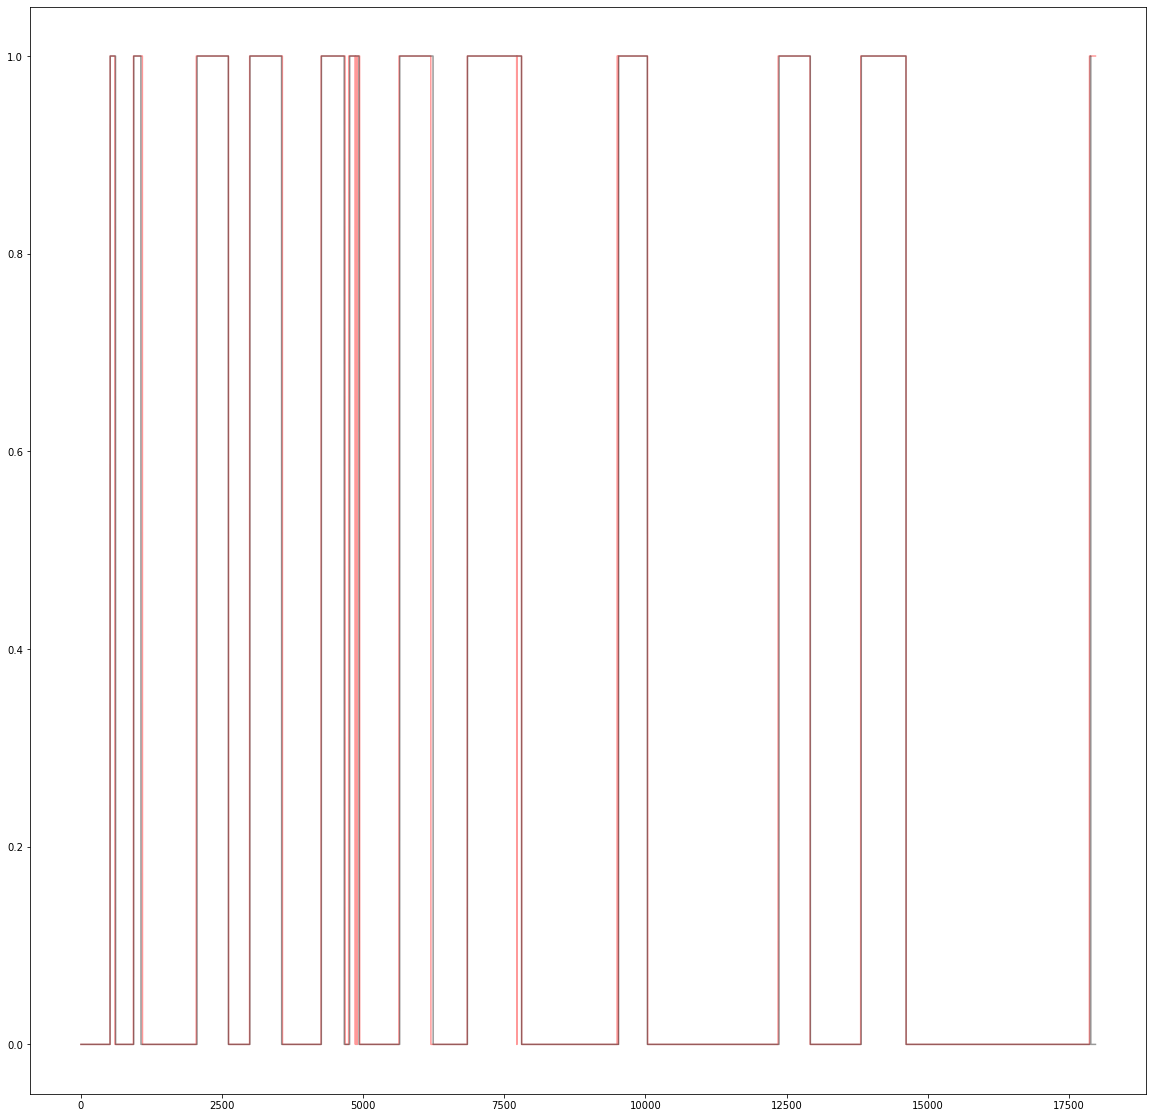

In [87]:
start=400
inc=400
plt.figure(figsize=(20,20))
plt.plot(aligned_df.in_box,'r',alpha=.4)
plt.plot(aligned_df.annots.in_light,'k',alpha=.4)
#plt.xlim([start,start+inc])

## building a classifier, random forest

### rears

In [89]:
annots_rears=pd.DataFrame()

for idx in annots.index:
    if "rear" in annots.Behavior[idx]:
        annots_rears=pd.concat([annots_rears,annots[annots.index==idx]],axis=0)

annots_rears=annots_rears.reset_index().drop(columns='index')

In [90]:
## add anns to df
aligned_df['annots','rear_supported']=float(0)
aligned_df['annots','rear_unsupported']=float(0)

In [91]:
for idx in np.arange(0,len(annots_rears),2):
    val1=int(round(annots_rears.adj_frame[idx]))
    val2=int(round(annots_rears.adj_frame[idx+1]))
    if "nsupported" in annots_rears.Behavior[idx]:
        #unsupported
        aligned_df.iloc[val1:val2,-1]=1
    else:
        #supported
        aligned_df.iloc[val1:val2,-2]=1

In [109]:
# make subsetted dataframe with just jumps
annots_jumps=pd.DataFrame()

for idx in annots.index:
    if "ump" in annots.Behavior[idx]:
        annots_jumps=pd.concat([annots_jumps,annots[annots.index==idx]],axis=0)

annots_jumps=annots_jumps.reset_index().drop(columns='index')
aligned_df['annots','jumps']=float(0)
for idx in np.arange(0,len(annots_jumps)):
    val1=int(round(annots_jumps.adj_frame[idx]-1))
    val2=int(round(annots_jumps.adj_frame[idx]+5))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ...    tail_tip            in_box  \
                  y likelihood      x  ...           y likelihood          
0      0.000000e+00   0.999926  500.0  ...         NaN   0.008444    0.0   
1     -1.428753e-14   0.999920  500.0  ...         NaN   0.010901    0.0   
2      0.000000e+00   0.999900  500.0  ...         NaN   0.010367    0.0   
3      0.000000e+00   0.999923  500.0  ...         NaN   0.014907    0.0   
4     -2.856428e-14   0.999883  500.0  ...         NaN   0.011806    0.0   
...             ...        ...    ...  ...         ...        ...    ...   
17969  0.000000e+00   0.999886  500.0  ...  185.406219   0.997880    1.0   
17970 -2.758458e-14   0.999876  500.0  ...  185.189346   0.998094    1.0   
17971  0.000000e+00   0.999853  500.0  ...  185.239502   0.997955    1.0   
17972  0.000000e+00   0.999842  500.0  ...  184.820328   0.997914    1.0   
17973  0.000000e+00   0.999882  500.0  ...  183.321564   0.998515    1.0   

        annots                                 jumps nose_tailbase_dist  \
      in_light rear_supported rear_unsupported                            
0            0            0.0              0.0   0.0                NaN   
1            0            0.0              0.0   0.0                NaN   
2            0            0.0              0.0   0.0                NaN   
3            0            0.0              0.0   0.0                NaN   
4            0            0.0              0.0   0.0                NaN   
...        ...            ...              ...   ...                ...   
17969        0            0.0              0.0   0.0          56.740811   
17970        0            0.0              0.0   0.0          58.604376   
17971        0            0.0              0.0   0.0          60.921719   
17972        0            0.0              0.0   0.0          63.406653   
17973        0            0.0              0.0   0.0          65.603762   

          speed annots  
                 jumps  
0      0.000000    0.0  
1           NaN    0.0  
2           NaN    0.0  
3           NaN    0.0  
4           NaN    0.0  
...         ...    ...  
17969  4.555700    0.0  
17970  5.999944    0.0  
17971  6.402273    0.0  
17972  7.251678    0.0  
17973  7.643364    0.0  

[17974 rows x 53 columns]

In [93]:
aligned_df['nose_tailbase_dist']=float(0)
aligned_df['speed']=float(0)

for idx in aligned_df.index:
    if idx%1000==0:
        print("on idx {} of {}".format(idx,aligned_df.index[-1]))
    rel_idx = idx-aligned_df.index[0]
    if rel_idx > 0:
        speed = math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.nose.x[idx-1],aligned_df.nose.y[idx-1]])
    else:
        speed=0
    aligned_df.iloc[rel_idx,-1]=speed
    aligned_df.iloc[rel_idx,-2]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_base.x[idx],aligned_df.tail_base.y[idx]])
aligned_df

on idx 0 of 17973
on idx 1000 of 17973
on idx 2000 of 17973
on idx 3000 of 17973
on idx 4000 of 17973
on idx 5000 of 17973
on idx 6000 of 17973
on idx 7000 of 17973
on idx 8000 of 17973
on idx 9000 of 17973
on idx 10000 of 17973
on idx 11000 of 17973
on idx 12000 of 17973
on idx 13000 of 17973
on idx 14000 of 17973
on idx 15000 of 17973
on idx 16000 of 17973
on idx 17000 of 17973


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ...   tail_tip                         \
                  y likelihood      x  ...          x           y likelihood   
0      0.000000e+00   0.999926  500.0  ...        NaN         NaN   0.008444   
1     -1.428753e-14   0.999920  500.0  ...        NaN         NaN   0.010901   
2      0.000000e+00   0.999900  500.0  ...        NaN         NaN   0.010367   
3      0.000000e+00   0.999923  500.0  ...        NaN         NaN   0.014907   
4     -2.856428e-14   0.999883  500.0  ...        NaN         NaN   0.011806   
...             ...        ...    ...  ...        ...         ...        ...   
17969  0.000000e+00   0.999886  500.0  ...  77.391563  185.406219   0.997880   
17970 -2.758458e-14   0.999876  500.0  ...  77.579056  185.189346   0.998094   
17971  0.000000e+00   0.999853  500.0  ...  77.627518  185.239502   0.997955   
17972  0.000000e+00   0.999842  500.0  ...  78.275650  184.820328   0.997914   
17973  0.000000e+00   0.999882  500.0  ...  80.488739  183.321564   0.998515   

      in_box   annots                                 jumps  \
             in_light rear_supported rear_unsupported         
0        0.0        0            0.0              0.0   0.0   
1        0.0        0            0.0              0.0   0.0   
2        0.0        0            0.0              0.0   0.0   
3        0.0        0            0.0              0.0   0.0   
4        0.0        0            0.0              0.0   0.0   
...      ...      ...            ...              ...   ...   
17969    1.0        0            0.0              0.0   0.0   
17970    1.0        0            0.0              0.0   0.0   
17971    1.0        0            0.0              0.0   0.0   
17972    1.0        0            0.0              0.0   0.0   
17973    1.0        0            0.0              0.0   0.0   

      nose_tailbase_dist     speed  
                                    
0                    NaN  0.000000  
1                    NaN       NaN  
2                    NaN       NaN  
3                    NaN       NaN  
4                    NaN       NaN  
...                  ...       ...  
17969          56.740811  4.555700  
17970          58.604376  5.999944  
17971          60.921719  6.402273  
17972          63.406653  7.251678  
17973          65.603762  7.643364  

[17974 rows x 52 columns]

In [94]:
np.sum(aligned_df.annots.rear_unsupported)

341.0

In [95]:
np.sum(aligned_df.annots.rear_supported)

1129.0

### make training and test data

In [158]:
df_for_training=aligned_df.drop(columns=['box_bl','box_br','box_tl','box_tr','opening_bottom','opening_top','in_box','jumps'])
df_for_training=df_for_training.drop(columns=df_for_training.columns[-6])
to_rm = []
for idx in np.arange(0,len(df_for_training.columns)):
    if "likelihood" in df_for_training.columns[idx]:
        to_rm.append(idx)
df_for_training=df_for_training.drop(columns=df_for_training.columns[to_rm])

C:\Users\dennise\Anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [159]:
df_for_training_annots=df_for_training.annots
df_for_training=df_for_training.drop(columns='annots')
df_for_training

ear_left              ear_right                   nose             \
                x          y           x          y           x          y   
0             NaN        NaN         NaN        NaN         NaN        NaN   
1             NaN        NaN         NaN        NaN         NaN        NaN   
2             NaN        NaN         NaN        NaN         NaN        NaN   
3             NaN        NaN         NaN        NaN         NaN        NaN   
4             NaN        NaN         NaN        NaN         NaN        NaN   
...           ...        ...         ...        ...         ...        ...   
17969  132.906891  86.766090  139.905624  84.335197  125.928253  71.330910   
17970  128.517136  86.152931  135.608994  82.332161  119.967941  70.642426   
17971  124.028381  86.139793  129.766373  81.124229  113.646049  69.631096   
17972  118.298248  84.862755  124.146515  79.232872  106.418182  69.043922   
17973  111.918831  82.933128  117.166779  76.360802   98.793785  68.505798   

      paw_left_back     paw_left_front     paw_right_back              \
                  x   y              x   y              x           y   
0               NaN NaN            NaN NaN            NaN         NaN   
1               NaN NaN            NaN NaN            NaN         NaN   
2               NaN NaN            NaN NaN            NaN         NaN   
3               NaN NaN            NaN NaN            NaN         NaN   
4               NaN NaN            NaN NaN            NaN         NaN   
...             ...  ..            ...  ..            ...         ...   
17969           NaN NaN            NaN NaN     152.430161  122.486923   
17970           NaN NaN            NaN NaN     152.328094  121.270653   
17971           NaN NaN            NaN NaN     152.326294  121.270546   
17972           NaN NaN            NaN NaN     152.328781  121.273064   
17973           NaN NaN            NaN NaN     152.330643  121.274223   

      paw_right_front       tail_base               tail_tip              \
                    x   y           x           y          x           y   
0                 NaN NaN         NaN         NaN        NaN         NaN   
1                 NaN NaN         NaN         NaN        NaN         NaN   
2                 NaN NaN         NaN         NaN        NaN         NaN   
3                 NaN NaN         NaN         NaN        NaN         NaN   
4                 NaN NaN         NaN         NaN        NaN         NaN   
...               ...  ..         ...         ...        ...         ...   
17969             NaN NaN  132.831360  127.650238  77.391563  185.406219   
17970             NaN NaN  132.903915  127.801270  77.579056  185.189346   
17971             NaN NaN  133.188095  127.333473  77.627518  185.239502   
17972             NaN NaN  133.631027  126.314026  78.275650  184.820328   
17973             NaN NaN  134.578949  123.490120  80.488739  183.321564   

      nose_tailbase_dist     speed  
                                    
0                    NaN  0.000000  
1                    NaN       NaN  
2                    NaN       NaN  
3                    NaN       NaN  
4                    NaN       NaN  
...                  ...       ...  
17969          56.740811  4.555700  
17970          58.604376  5.999944  
17971          60.921719  6.402273  
17972          63.406653  7.251678  
17973          65.603762  7.643364  

[17974 rows x 20 columns]

In [162]:
from sklearn.ensemble import RandomForestClassifier

In [355]:
xVar=df_for_training.columns
yVar=df_for_training_annots.rear_unsupported
df_for_training=df_for_training.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(df_for_training, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(14379, 20) (14379,)
(3595, 20) (3595,)


In [356]:
clf = RandomForestClassifier(n_jobs=4, random_state=0)

clf.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,3520,2
1.0,21,52


In [357]:
all_preds = clf.predict(df_for_training)

Text(0.5, 1.0, 'predicted in dark blue')

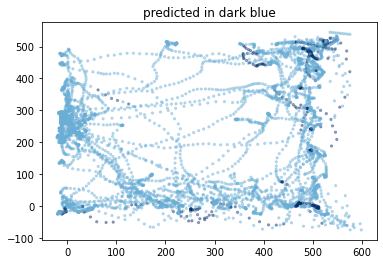

In [431]:
plt.scatter(df_for_training.nose.x,df_for_training.nose.y,c=all_preds,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('predicted in dark blue')

Text(0.5, 1.0, 'ground truth in dark blue')

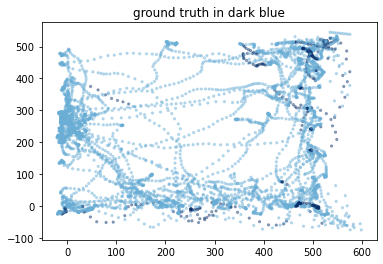

In [430]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('ground truth in dark blue')

Text(0.5, 1.0, 'predicted in yellow, ground truth in cyan')

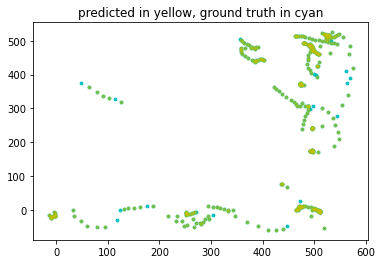

In [432]:
plt.scatter(aligned_df.nose.x[yVar==1],aligned_df.nose.y[yVar==1],s=8,c='c')
plt.scatter(df_for_training.nose.x[all_preds==1],df_for_training.nose.y[all_preds==1],c='y',s=8,alpha=0.5)
plt.title('predicted in yellow, ground truth in cyan')

In [433]:
# list features, their contribution
list(zip(X_train, clf.feature_importances_))

[(('ear_left', 'x'), 0.05913611562207431),
 (('ear_left', 'y'), 0.04325062617722917),
 (('ear_right', 'x'), 0.06047880842190416),
 (('ear_right', 'y'), 0.04900940927163401),
 (('nose', 'x'), 0.053254230978965346),
 (('nose', 'y'), 0.05475137011727251),
 (('paw_left_back', 'x'), 0.02190384360758602),
 (('paw_left_back', 'y'), 0.04430808724544625),
 (('paw_left_front', 'x'), 0.03766869785224116),
 (('paw_left_front', 'y'), 0.02267580015812897),
 (('paw_right_back', 'x'), 0.049069686716690375),
 (('paw_right_back', 'y'), 0.040837978564650344),
 (('paw_right_front', 'x'), 0.04393066146607195),
 (('paw_right_front', 'y'), 0.04782888110307313),
 (('tail_base', 'x'), 0.06391607601261762),
 (('tail_base', 'y'), 0.053621734420952014),
 (('tail_tip', 'x'), 0.08365717814918074),
 (('tail_tip', 'y'), 0.06855155589009879),
 (('nose_tailbase_dist', ''), 0.05644316594112144),
 (('speed', ''), 0.04570609228306183)]

# TODOs
- add classifier output to csv, save out
- add Alex to lab GitHub
- turn into scripts
- check additional ground truth data
- if looks good and Alex is happy, process all the videos
    - DLC analysis of video
    - run script on each output csv
    - send to Alex